### Required Try-It Activity 14.1: Grid Searching Decision Trees 

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,
                                     HalvingGridSearchCV, HalvingRandomSearchCV)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import time

In [29]:
# Load Whickham data instead of breast cancer data
df = pd.read_csv('data/Whickham.txt')

print("📊 Whickham Dataset Overview:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nOutcome distribution:")
print(df['outcome'].value_counts())
print(f"\nSmoker distribution:")
print(df['smoker'].value_counts())

# Prepare the data
# Encode categorical variables
le_outcome = LabelEncoder()
le_smoker = LabelEncoder()

# Create features and target
X = df[['age']].copy()  # Start with age as numerical feature
X['smoker_encoded'] = le_smoker.fit_transform(df['smoker'])  # Add encoded smoker status

y = le_outcome.fit_transform(df['outcome'])  # Encode outcome (Alive=0, Dead=1)

print(f"\nFeatures shape: {X.shape}")
print(f"Target classes: {le_outcome.classes_}")
print(f"Smoker encoding: No=0, Yes=1")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n🔍 Comparing All 4 Grid Search Methods")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

📊 Whickham Dataset Overview:
  outcome smoker  age
0   Alive    Yes   23
1   Alive    Yes   18
2    Dead    Yes   71
3   Alive     No   67
4   Alive     No   64

Dataset shape: (1314, 3)

Outcome distribution:
outcome
Alive    945
Dead     369
Name: count, dtype: int64

Smoker distribution:
smoker
No     732
Yes    582
Name: count, dtype: int64

Features shape: (1314, 2)
Target classes: ['Alive' 'Dead']
Smoker encoding: No=0, Yes=1

🔍 Comparing All 4 Grid Search Methods
Training set size: (1051, 2)
Test set size: (263, 2)


### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [ ]:
# # Load data
# X, y = load_breast_cancer(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("🔍 Comparing All 4 Grid Search Methods")
# print("Dataset size:", X_train.shape)


🔍 Comparing All 4 Grid Search Methods
Dataset size: (455, 30)


In [ ]:
# # Parameter grid
# params = {
#     'max_depth': [3, 5, 10, None],
#     'min_samples_split': [2, 10, 20],
#     'criterion': ['gini', 'entropy']
# }

# total_combinations = np.prod([len(v) for v in params.values()])
# print(f"Total parameter combinations: {total_combinations}")



Total parameter combinations: 24


In [30]:
# Initialize results storage
results = {}

In [31]:
# Method 1: GridSearchCV - Tests ALL combinations
print("\n1️⃣ GridSearchCV - Tests ALL combinations")
start = time.time()
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42), 
    params, 
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_time = time.time() - start

results['GridSearchCV'] = {
    'Time': grid_time,
    'Score': grid_search.best_score_,
    'Params': grid_search.best_params_,
    'Total_Fits': len(grid_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {grid_time:.2f} seconds")
print(f"   🎯 Best score: {grid_search.best_score_:.4f}")
print(f"   📊 Tested: {len(grid_search.cv_results_['params'])} combinations")



1️⃣ GridSearchCV - Tests ALL combinations
   ⏱️ Time: 2.92 seconds
   🎯 Best score: 0.8516
   📊 Tested: 24 combinations


In [32]:
# Method 2: RandomizedSearchCV - Tests random sample
print("\n2️⃣ RandomizedSearchCV - Tests RANDOM sample")
start = time.time()
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42), 
    params, 
    n_iter=15,  # Test 15 random combinations
    cv=3, 
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
random_time = time.time() - start

results['RandomizedSearchCV'] = {
    'Time': random_time,
    'Score': random_search.best_score_,
    'Params': random_search.best_params_,
    'Total_Fits': len(random_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {random_time:.2f} seconds")
print(f"   🎯 Best score: {random_search.best_score_:.4f}")
print(f"   📊 Tested: {len(random_search.cv_results_['params'])} combinations")




2️⃣ RandomizedSearchCV - Tests RANDOM sample
   ⏱️ Time: 1.24 seconds
   🎯 Best score: 0.8516
   📊 Tested: 15 combinations


In [33]:
# Method 3: HalvingGridSearchCV - Iteratively eliminates poor performers
print("\n3️⃣ HalvingGridSearchCV - ELIMINATES poor performers")
start = time.time()
halving_grid_search = HalvingGridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    cv=3,
    random_state=42,
    n_jobs=-1
)
halving_grid_search.fit(X_train, y_train)
halving_grid_time = time.time() - start

results['HalvingGridSearchCV'] = {
    'Time': halving_grid_time,
    'Score': halving_grid_search.best_score_,
    'Params': halving_grid_search.best_params_,
    'Total_Fits': len(halving_grid_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {halving_grid_time:.2f} seconds")
print(f"   🎯 Best score: {halving_grid_search.best_score_:.4f}")
print(f"   📊 Tested: {len(halving_grid_search.cv_results_['params'])} combinations")




3️⃣ HalvingGridSearchCV - ELIMINATES poor performers
   ⏱️ Time: 0.12 seconds
   🎯 Best score: 0.8522
   📊 Tested: 35 combinations


In [34]:
# Method 4: HalvingRandomSearchCV - Random + halving strategy
print("\n4️⃣ HalvingRandomSearchCV - RANDOM + halving")
start = time.time()
halving_random_search = HalvingRandomSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    cv=3,
    random_state=42,
    n_jobs=-1
)
halving_random_search.fit(X_train, y_train)
halving_random_time = time.time() - start

results['HalvingRandomSearchCV'] = {
    'Time': halving_random_time,
    'Score': halving_random_search.best_score_,
    'Params': halving_random_search.best_params_,
    'Total_Fits': len(halving_random_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {halving_random_time:.2f} seconds")
print(f"   🎯 Best score: {halving_random_search.best_score_:.4f}")
print(f"   📊 Tested: {len(halving_random_search.cv_results_['params'])} combinations")




4️⃣ HalvingRandomSearchCV - RANDOM + halving
   ⏱️ Time: 0.11 seconds
   🎯 Best score: 0.8677
   📊 Tested: 35 combinations


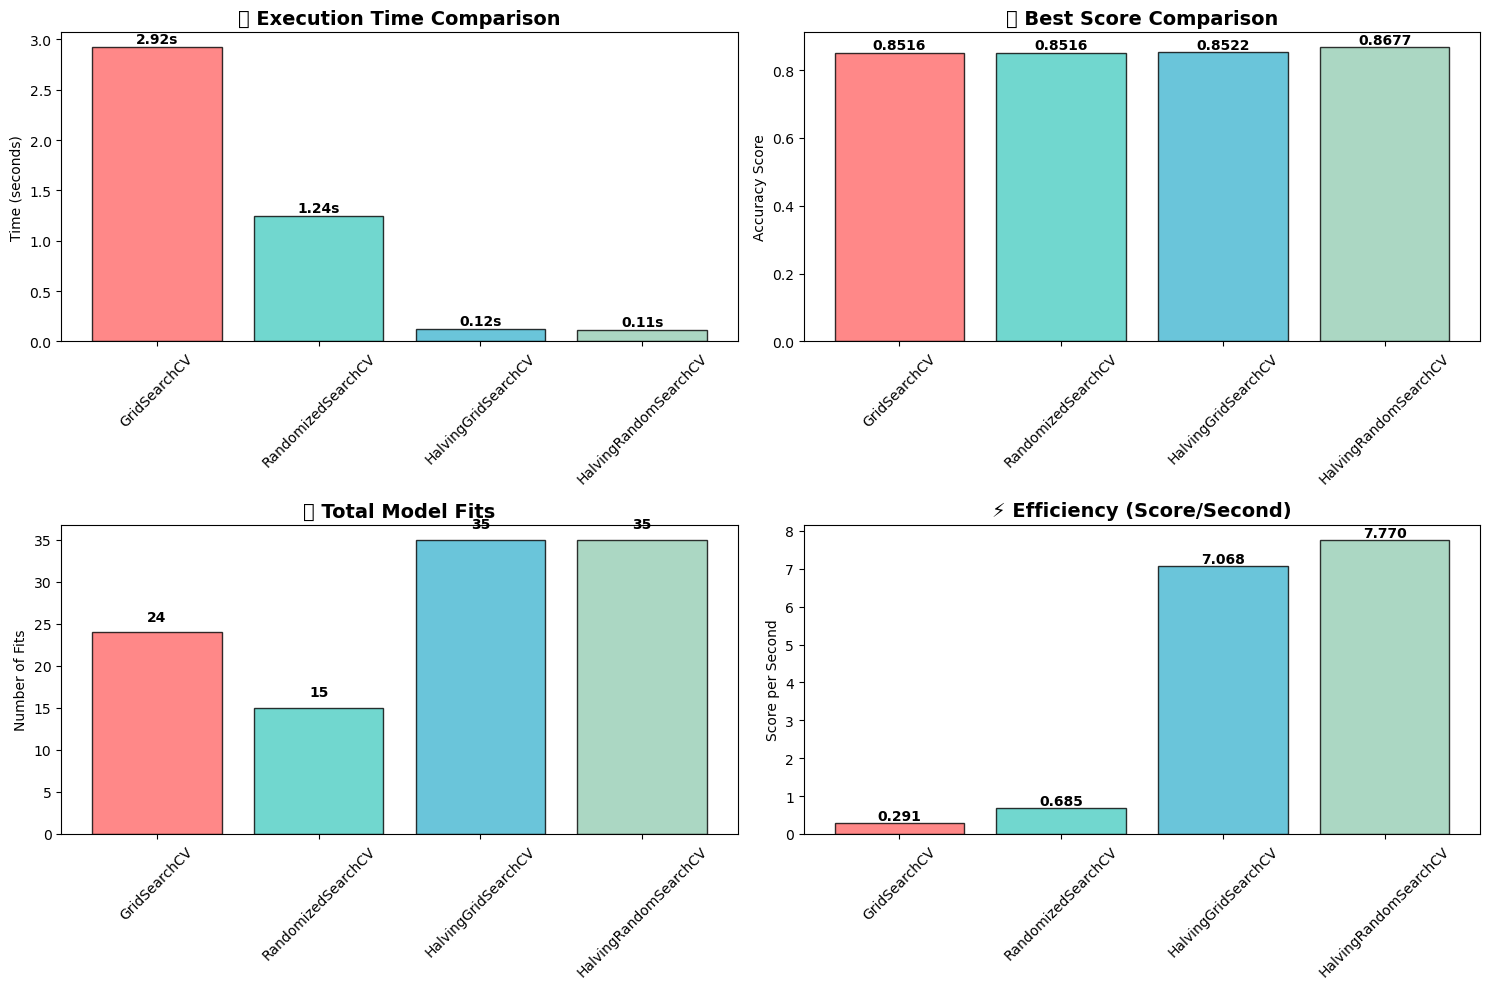

In [35]:
# Create comparison visualization
methods = list(results.keys())
times = [results[method]['Time'] for method in methods]
scores = [results[method]['Score'] for method in methods]
total_fits = [results[method]['Total_Fits'] for method in methods]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Time Comparison
bars1 = ax1.bar(methods, times, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('⏱️ Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.tick_params(axis='x', rotation=45)
for bar, time_val in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
# 2. Best Score Comparison
bars2 = ax2.bar(methods, scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('🎯 Best Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy Score')
ax2.tick_params(axis='x', rotation=45)
for bar, score in zip(bars2, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
# 3. Total Fits Comparison
bars3 = ax3.bar(methods, total_fits, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('📊 Total Model Fits', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Fits')
ax3.tick_params(axis='x', rotation=45)
for bar, fits in zip(bars3, total_fits):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{fits}', ha='center', va='bottom', fontweight='bold')
    
# 4. Efficiency (Score per Second)
efficiency = [score/time_val for score, time_val in zip(scores, times)]
bars4 = ax4.bar(methods, efficiency, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('⚡ Efficiency (Score/Second)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score per Second')
ax4.tick_params(axis='x', rotation=45)
for bar, eff in zip(bars4, efficiency):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{eff:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/search_comparison.jpg', dpi=300, bbox_inches='tight')
plt.show()    

In [36]:
# Results summary table
results_df = pd.DataFrame(results).T
results_df['Efficiency'] = results_df['Score'] / results_df['Time']
results_df = results_df.round(4)

print("\n" + "="*60)
print("📋 DETAILED RESULTS TABLE")
print("="*60)
print(results_df[['Time', 'Score', 'Total_Fits', 'Efficiency']].to_string())

# Analysis and recommendations
print("\n" + "="*60)
print("🔍 ANALYSIS & RECOMMENDATIONS")
print("="*60)

fastest_method = min(results.keys(), key=lambda x: results[x]['Time'])
highest_score = max(results.keys(), key=lambda x: results[x]['Score'])
most_efficient = max(results.keys(), key=lambda x: results[x]['Score']/results[x]['Time'])

print(f"\n🚀 FASTEST: {fastest_method} ({results[fastest_method]['Time']:.2f}s)")
print(f"🎯 HIGHEST SCORE: {highest_score} ({results[highest_score]['Score']:.4f})")
print(f"⚡ MOST EFFICIENT: {most_efficient} ({results[most_efficient]['Score']/results[most_efficient]['Time']:.3f})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • GridSearchCV: Most thorough but slowest ({results['GridSearchCV']['Total_Fits']} fits)")
print(f"   • RandomizedSearchCV: Good balance ({results['RandomizedSearchCV']['Total_Fits']} fits)")
print(f"   • HalvingGridSearchCV: Fast with systematic elimination ({results['HalvingGridSearchCV']['Total_Fits']} fits)")
print(f"   • HalvingRandomSearchCV: Fastest with smart sampling ({results['HalvingRandomSearchCV']['Total_Fits']} fits)")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   ✅ For SMALL datasets: Use GridSearchCV (thorough)")
print(f"   ✅ For LARGE datasets: Use HalvingRandomSearchCV (fastest)")
print(f"   ✅ For EXPLORATION: Use RandomizedSearchCV (good balance)")
print(f"   ✅ For EFFICIENCY: Use {most_efficient} (best score/time ratio)")



📋 DETAILED RESULTS TABLE
                           Time     Score Total_Fits Efficiency
GridSearchCV           2.923147   0.85157         24   0.291319
RandomizedSearchCV     1.242962   0.85157         15   0.685113
HalvingGridSearchCV    0.120573  0.852206         35   7.067979
HalvingRandomSearchCV  0.111672  0.867725         35   7.770288

🔍 ANALYSIS & RECOMMENDATIONS

🚀 FASTEST: HalvingRandomSearchCV (0.11s)
🎯 HIGHEST SCORE: HalvingRandomSearchCV (0.8677)
⚡ MOST EFFICIENT: HalvingRandomSearchCV (7.770)

💡 KEY INSIGHTS:
   • GridSearchCV: Most thorough but slowest (24 fits)
   • RandomizedSearchCV: Good balance (15 fits)
   • HalvingGridSearchCV: Fast with systematic elimination (35 fits)
   • HalvingRandomSearchCV: Fastest with smart sampling (35 fits)

🎯 RECOMMENDATIONS:
   ✅ For SMALL datasets: Use GridSearchCV (thorough)
   ✅ For LARGE datasets: Use HalvingRandomSearchCV (fastest)
   ✅ For EXPLORATION: Use RandomizedSearchCV (good balance)
   ✅ For EFFICIENCY: Use HalvingRando

In [37]:
# Best parameters comparison
print(f"\n🏆 BEST PARAMETERS FOUND:")
for method, data in results.items():
    print(f"   {method}: {data['Params']}")

print(f"\n🎉 Analysis complete! All methods found good hyperparameters.")


🏆 BEST PARAMETERS FOUND:
   GridSearchCV: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
   RandomizedSearchCV: {'min_samples_split': 2, 'max_depth': 3, 'criterion': 'gini'}
   HalvingGridSearchCV: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
   HalvingRandomSearchCV: {'min_samples_split': 10, 'max_depth': None, 'criterion': 'entropy'}

🎉 Analysis complete! All methods found good hyperparameters.
